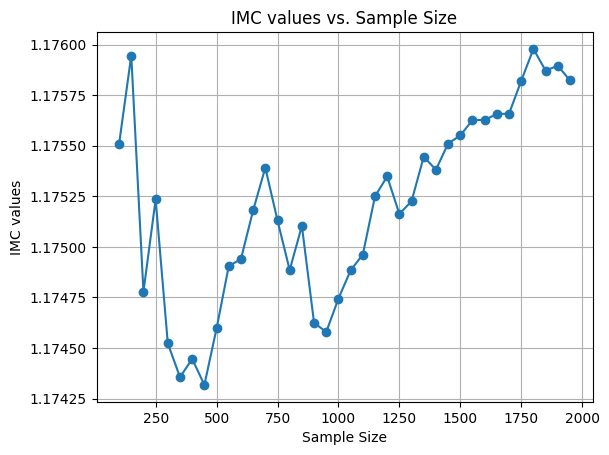

In [68]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Initial values
y0 = [0, 0]
eps=0.08
I=1
seedMC=1234 #Seed to reproduce results

# Time span and step size
t_span = [0, 10]
h = 0.01

#Define the system but with a and b as parameters
def f(t, y, a, b):
    dy1_dt = y[0] - (y[0]**3)/3 - y[1]+I
    dy2_dt = eps*(y[0] + a - b*y[1])
    return [dy1_dt, dy2_dt]

#Define the forward Euler method
def forward_euler_system(f, y0, t_span, h, a, b):
    t_values = np.arange(t_span[0], t_span[1] + h, h)
    y_values = [y0]

    for t in t_values[:-1]:
        y_next = y_values[-1] + h * np.array(f(t, y_values[-1], a, b))
        y_values.append(y_next)

    return t_values, np.array(y_values)

#Compute the quantity of interest with respect to a and b
#where a is in [0.6, 0.8] and b in [0.7, 0.9]
def Q(a,b):

    t_values, y_values = forward_euler_system(f, y0, t_span, h, a, b) #Solve the system of ODEs
    S=0
    for i in range (len(y_values)-1):
        S+= (y_values[i,0]**2 +y_values[i+1,0]**2)/2
    return S*h

#Compute the Monte Carlo estimator to approach I
#with size of samples of M
def IMC(M,seed):
    area=(0.2)**2
    np.random.seed(seed)
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    I=0
    for j in range (M):
        I+=Q(A[j],B[j])
    
    return I*area/M

# Plotting
sample_sizes = np.arange(100, 2000, 50)
values = [IMC(size,seedMC) for size in sample_sizes]
plt.plot(sample_sizes, values, marker='o')
plt.title('IMC values vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('IMC values')
plt.grid(True)
plt.show()








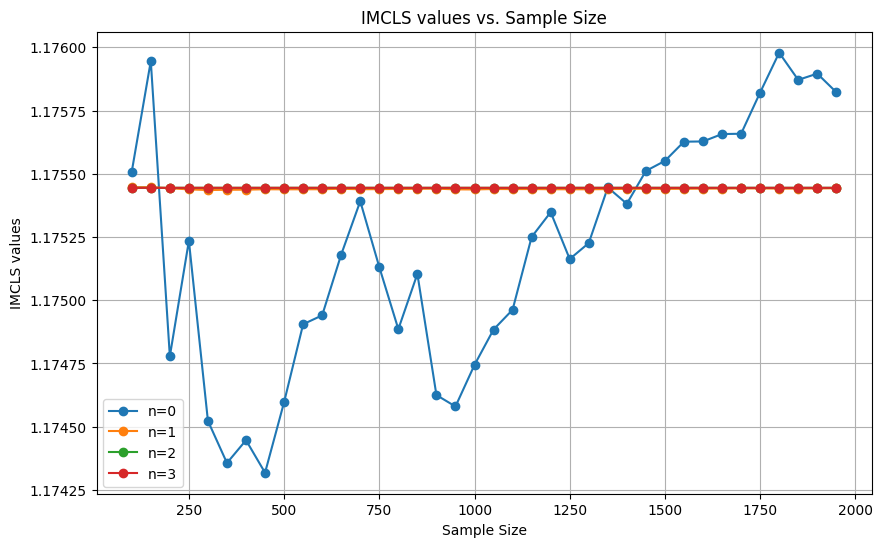

In [71]:

import numpy.polynomial.legendre as L


seedMCLS1=1234
seedMCLS2=1235

def degree(n):
    if n!=0:
        list_=[0]*(n+1)
        list_[-1]=1
        return list_
    if n==0:
        return [1,0] #small fix, [1,0] is equivalent to [1] but they didn't like [1]

#Since we are computing a double integral, we adapt the method to our need. We are working with the following orthonormal basis (L_i(x)*L_j(y)) for i,j=0,...,N and L_i
#is the Legendre polynomial of degree. The column of the matrix are just the evaluation of each vector of the basis at the samples (a_i,b_i) from i=1,...,M.
def V_mat(M, N, A ,B):
    V=np.ones((M,(N+1)**2))
    counter=0
    for i in range(0,N+1):
        for j in range(0,N+1):
            #We need the legendre polynomials with two variables
            l_i=np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0.6, 0.8]) #normalization coefficient to ensure orthonormality of
            l_j=np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0.7, 0.9])
            V[:,counter]=[l_i(x)*l_j(y) for x,y in zip(A,B)] #Each column is the vector []
            counter+=1
    return V, np.linalg.cond(V)

#Again, we adapt the function to our function
#We want to find the coefficients that minimize Q(a_m,b_m) - \sum_{1\leq i,j \leq n} c_{i,j}*L_i(a_m)*L_j(b_m) 
def coefficient(M, N,seed):
    np.random.seed(seed) #for reproducibility
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    V, cond_V=V_mat(M, N, A, B) #Defining the matrix
    Q_eval=np.array([Q(a,b) for a,b in zip(A,B)]) #Computing Q(A,B)
    c_coeff,_,_,_=np.linalg.lstsq(V,Q_eval, rcond=10**(-5)) #Finding the coefficients
    return c_coeff, cond_V

#Computing the inegral using the Monte Carlo Least Square estimator with sample size M
# and taking N^2 polynomials from the basis (L_i(x)*L_j(y)) for i,j=1,...,n  
def IMCLS(M, N,seed_1,seed_2):
    area=(0.2)**2
    np.random.seed(seed_1)
    A=np.random.uniform(0.6, 0.8,size=M)
    B=np.random.uniform(0.7,0.9,size=M)
    c_coeff, cond_V=coefficient(M, N,seed_2) #We use different seed, since we don't use the same samples to compute the coefficients.
    l_array=lambda x,y,n: np.array([np.sqrt(2*i+1)*L.Legendre(degree(i), domain=[0.6,0.8])(x)*
                                    np.sqrt(2*j+1)*L.Legendre(degree(j), domain=[0.7,0.9])(y) for i in range(0,n+1) for j in 
                                     range(0,n+1) ])
    Q_array=np.array([Q(x,y)-c_coeff@l_array(x,y, N) for x,y in zip(A,B)]) #Evaluating Q(a_m,b_m) - \sum_{1\leq i,j \leq n} c_{i,j}*L_i(a_m)*L_j(b_m) for each sample
    
    Error=np.std(Q_array) #We compute the standard deviation as this will be our error estimator.
    
    IMCLS_value=np.mean(Q_array)+c_coeff[0]
    IMCLS_prime_val=c_coeff[0]
    return IMCLS_value*area, Error


fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over different values of n
for n in range(4):
    sample_sizes = np.arange(100, 2000, 50)
    values = [IMCLS(size, n, seedMCLS1, seedMCLS2) for size in sample_sizes]

    # Plotting with different colors for each value of n
    ax.plot(sample_sizes, values, marker='o', label=f'n={n}')

# Set labels and title
ax.set_title('IMCLS values vs. Sample Size')
ax.set_xlabel('Sample Size')
ax.set_ylabel('IMCLS values')
ax.legend()  # Show legend with labels for each value of n
ax.grid(True)

# Show the figure
plt.show()
